# Chest X-Ray - Pneumonia Detection using CNN

Dincer, T. (n.d.). Labeled chest X-ray images [Data set]. Kaggle. https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

### Problem and Data Overview

Pneumonia is a serious lung infection that is a leading cause of death in children under 5 years of age. The presence of this disease can be confirmed using chest X-rays. This dataset contains over 5,000 images of chest X-rays, sourced from Guangzhou Women and Children's Medical Center in China, that are either categorized as normal, bacterial pneumonia, or viral pneumonia. For simplicity, this project will focus on detecting the presence or absence of pneumonia, disregarding whether the pneumonia is bacterial or viral. This dataset is already split into a training and testing set.

For this project, we will try to find the best convolutional neural network architecture that is able to detect the presence of pneumonia based on chest X-ray images. Keras from Tensorflow will be used. Our objective is to be able to detect the presence of this disease with sufficient accuracy while also putting emphasis on the recall score to minimize the risk of failing to identify patients with pneumonia.

### Importing Libraries

In [314]:
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

### Importing the Dataset

In [6]:
#importing the dataset directly from kaggle
source = "kaggle.json"
destination_dir = os.path.expanduser("~/.kaggle")
destination_file = os.path.join(destination_dir, "kaggle.json")

os.makedirs(destination_dir, exist_ok=True)

shutil.move(source, destination_file)

os.chmod(destination_file, 0o600)

In [8]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
os.listdir()

['ChestXRay.ipynb',
 '.DS_Store',
 'labeled-chest-xray-images.zip',
 '.ipynb_checkpoints',
 'labeled-chest-xray-images',
 'LPneumonia.ipynb',
 'NewChestXRay.ipynb']

In [10]:
with zipfile.ZipFile("labeled-chest-xray-images.zip", "r") as zip_ref:
    zip_ref.extractall("labeled-chest-xray-images")

### EDA

#### Viewing Images

In [16]:
base_path = "chest_xray_data"
os.listdir()

['ChestXRay.ipynb',
 '.DS_Store',
 'labeled-chest-xray-images.zip',
 '.ipynb_checkpoints',
 'labeled-chest-xray-images',
 'LPneumonia.ipynb',
 'NewChestXRay.ipynb']

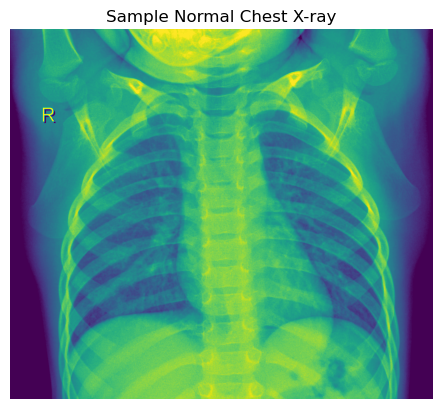

In [18]:
#printing a training image in the "NORMAL" folder

#defining the directory
img_path = os.path.join("labeled-chest-xray-images", "chest_xray", "train", "NORMAL")
img_file = os.listdir(img_path)[0]

#opening the image
img = Image.open(os.path.join(img_path, img_file))
plt.imshow(img)
plt.title("Sample Normal Chest X-ray")
plt.axis('off')
plt.show()

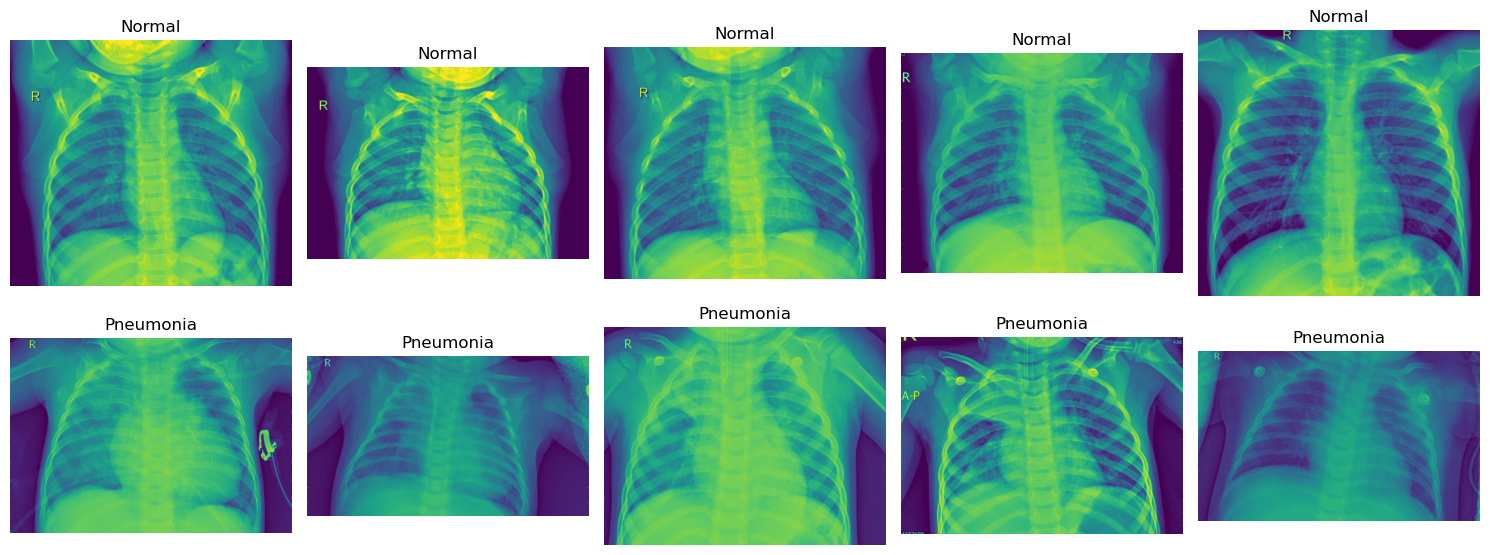

In [20]:
#printing 5 normal and 5 pneumonia images

#define the directories
base_dir = os.path.join("labeled-chest-xray-images", "chest_xray", "train")
normal_dir = os.path.join(base_dir, "NORMAL")
pneumonia_dir = os.path.join(base_dir, "PNEUMONIA")

#pulling the names of the first 5 images in each folder
normal_imgs = os.listdir(normal_dir)[:5]
pneumonia_imgs = os.listdir(pneumonia_dir)[:5]

#plotting the images using matplotlib
plt.figure(figsize=(15, 6))
for i, file in enumerate(normal_imgs):
    img = Image.open(os.path.join(normal_dir, file))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Normal")
    plt.axis('off')
for i, file in enumerate(pneumonia_imgs):
    img = Image.open(os.path.join(pneumonia_dir, file))
    plt.subplot(2, 5, i + 6)  # Start from subplot 6
    plt.imshow(img)
    plt.title("Pneumonia")
    plt.axis('off')
plt.tight_layout()
plt.show()

The images are of different sizes. Let's standardize them:

#### Standardizing Images to the Same Size

In [24]:
#checking to see the largest image size
folder_paths = [
    os.path.join("labeled-chest-xray-images", "chest_xray", "train", "NORMAL"),
    os.path.join("labeled-chest-xray-images", "chest_xray", "train", "PNEUMONIA"),
    os.path.join("labeled-chest-xray-images", "chest_xray", "test", "NORMAL"),
    os.path.join("labeled-chest-xray-images", "chest_xray", "test", "PNEUMONIA")
]
    
unique_sizes = set()

for folder_path in folder_paths:
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        with Image.open(img_path) as img:
            unique_sizes.add(img.size)

max_width = max([size[0] for size in unique_sizes])
max_height = max([size[1] for size in unique_sizes])

print(f"Largest width: {max_width}")
print(f"Largest height: {max_height}")

Largest width: 2916
Largest height: 2713


In [35]:
#resizing all the images to make them of size 256x256
target_size = (256, 256)

for folder_path in tqdm(folder_paths):
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        with Image.open(img_path) as image:
            resized_image = image.resize(target_size)
            resized_image.save(img_path)

100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.06s/it]


Looking at the resized images:

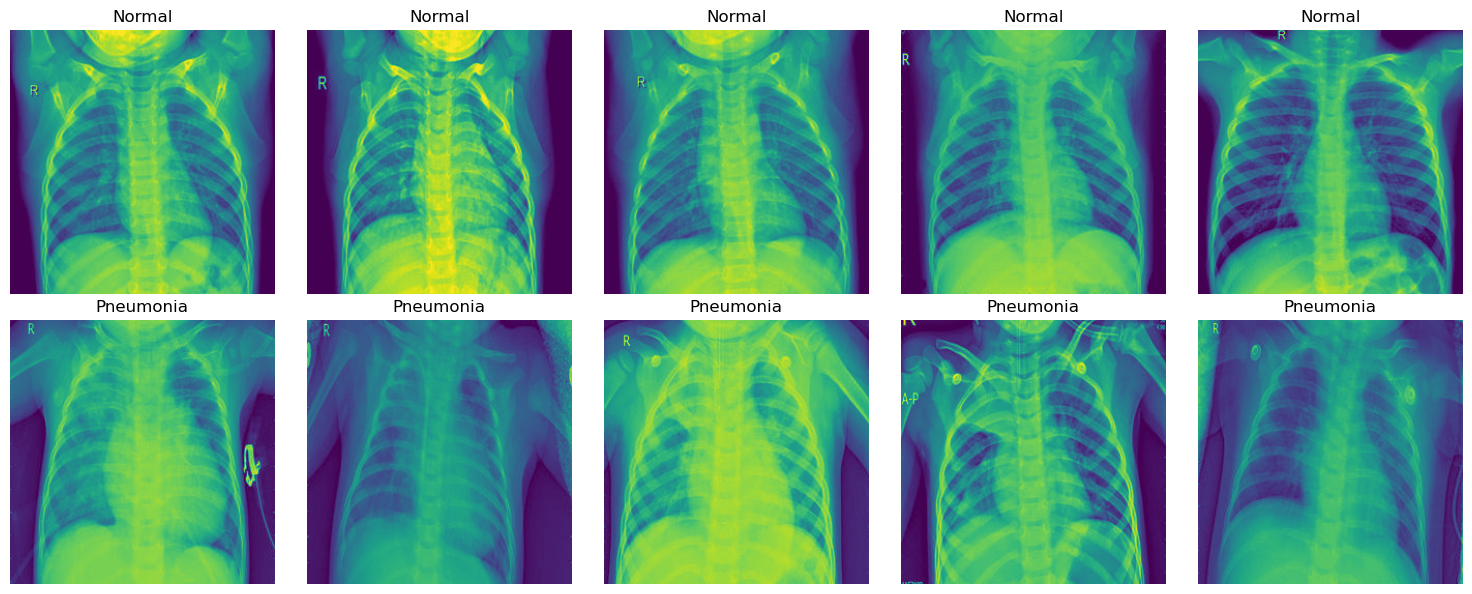

In [38]:
#printing resized images (5 normal and 5 pneumonia)

#pulling the names of the first 5 images in each folder
normal_imgs = os.listdir(normal_dir)[:5]
pneumonia_imgs = os.listdir(pneumonia_dir)[:5]

#plotting the images using matplotlib
plt.figure(figsize=(15, 6))
for i, file in enumerate(normal_imgs):
    img = Image.open(os.path.join(normal_dir, file))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Normal")
    plt.axis('off')
for i, file in enumerate(pneumonia_imgs):
    img = Image.open(os.path.join(pneumonia_dir, file))
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.title("Pneumonia")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
#ensuring all the images are of the correct size
unique_sizes = set()

for folder_path in folder_paths:
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        with Image.open(img_path) as img:
            unique_sizes.add(img.size)

print("Unique image sizes:")
for size in sorted(unique_sizes):
    print(size)

Unique image sizes:
(256, 256)


We can see that in the chest X-rays, there are very subtle differences between patients with pneumonia and those without pneumonia. In order to catch these subtle differences, we will build our model using alternating 2D convolutional layers with a ReLU activation function and max-pooling layers. This will help us detect complex features or patterns while also reducing unnecessary noise.

We can also see that these images are read in RGB format. We will convert the images to grayscale since X-rays are grayscale in nature.

#### Barplot of Class Distribution

In [44]:
train_data_path = "labeled-chest-xray-images/chest_xray/train"

class_folders = [cls for cls in os.listdir(train_data_path)
                 if os.path.isdir(os.path.join(train_data_path, cls))]

counts = {cls: len(os.listdir(os.path.join(train_data_path, cls)))
          for cls in class_folders}

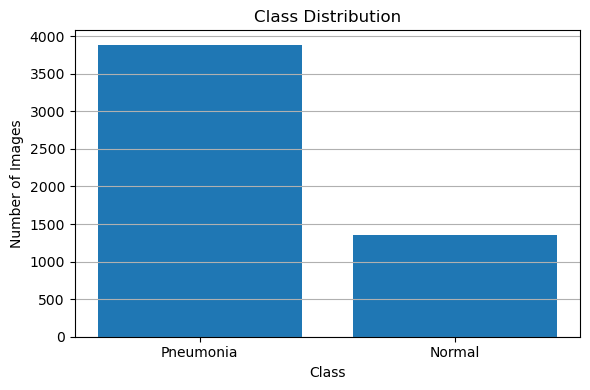

In [46]:
classes = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(6, 4))
plt.bar(classes, values)

plt.title("Class Distribution")
plt.xlabel("Class")
plt.xticks(ticks = [0, 1], labels = ["Pneumonia", "Normal"])
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We can see that the data is not balanced; the pneumonia class is favored in that it has more instances. We need to balance this dataset to ensure that the model sees and is trained on an even amount of both classes.

### Data Preprocessing

We will convert each of the images into arrays of size 256 x 256 x 1 (since we are working in grayscale) and concatenate all the image arrays together.

In [50]:
#converting normal training x-rays into RGB arrays
folder_path = 'labeled-chest-xray-images/chest_xray/train/NORMAL'
X_train_normal = []

for image_file in tqdm(os.listdir(folder_path)):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    X_train_normal.append(img_array)

X_train_normal = np.stack(X_train_normal)

print(X_train_normal.shape)

100%|█████████████████████████████████████| 1349/1349 [00:00<00:00, 2925.58it/s]

(1349, 256, 256)


In [52]:
#converting pneumonia training x-rays into RGB and grayscale arrays
folder_path = 'labeled-chest-xray-images/chest_xray/train/PNEUMONIA'
X_train_pneumonia = []

for image_file in tqdm(os.listdir(folder_path)):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    X_train_pneumonia.append(img_array)

X_train_pneumonia = np.stack(X_train_pneumonia)

print(X_train_pneumonia.shape)

100%|█████████████████████████████████████| 3883/3883 [00:01<00:00, 3577.28it/s]


(3883, 256, 256)


In [54]:
#converting normal testing x-rays into RGB and grayscale arrays
folder_path = 'labeled-chest-xray-images/chest_xray/test/NORMAL'
X_test_normal = []

for image_file in tqdm(os.listdir(folder_path)):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    X_test_normal.append(img_array)

X_test_normal = np.stack(X_test_normal)

print(X_test_normal.shape)

100%|███████████████████████████████████████| 234/234 [00:00<00:00, 2603.18it/s]

(234, 256, 256)


In [56]:
#converting pneumonia testing x-rays into RGB and grayscale arrays
folder_path = 'labeled-chest-xray-images/chest_xray/test/PNEUMONIA'
X_test_pneumonia = []

for image_file in tqdm(os.listdir(folder_path)):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    X_test_pneumonia.append(img_array)

X_test_pneumonia = np.stack(X_test_pneumonia)

print(X_test_pneumonia.shape)

100%|███████████████████████████████████████| 390/390 [00:00<00:00, 3025.72it/s]

(390, 256, 256)


Since the dataset came in 4 different folders separating the training dataset from the testing dataset and normal cases from pneumonia cases, we will combine all the training images together with their associated labels. We will do the same for the testing images.

In addition, we will balance our dataset here so that we have an approximately equal number of pneumonia and normal images.

In [102]:
indices = np.random.choice(len(X_train_pneumonia), size=len(X_train_normal), replace=False)

X_train_pneumonia = X_train_pneumonia[indices]
print(X_train_pneumonia.shape)

(1349, 256, 256)


In [104]:
X_train = np.concatenate((X_train_normal, X_train_pneumonia), axis = 0)
len(X_train)

2698

In [106]:
Y_train_normal = np.zeros(len(X_train_normal))
print(len(Y_train_normal))

1349


In [108]:
Y_train_pneumonia = np.ones(len(X_train_pneumonia))
print(len(Y_train_pneumonia))

1349


In [110]:
Y_train = np.concatenate((Y_train_normal, Y_train_pneumonia), axis = 0)
print(len(Y_train))

2698


In [112]:
X_test = np.concatenate((X_test_normal, X_test_pneumonia), axis = 0)
len(X_test)

624

In [114]:
Y_test_normal = np.zeros(len(X_test_normal))
print(len(Y_test_normal))

234


In [116]:
Y_test_pneumonia = np.ones(len(X_test_pneumonia))
print(len(Y_test_pneumonia))

390


In [118]:
Y_test = np.concatenate((Y_test_normal, Y_test_pneumonia), axis = 0)
len(Y_test)

624

We will shuffle the arrays so that the positive and negative cases are mixed.

In [121]:
#shuffling the colored cases
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 42)

Instead of working with 2698 images, we will take a smaller sample of 1000 and work with that to reduce computational time.

In [124]:
#taking a smaller sample of each array
indices = np.random.choice(len(X_train), size=1000, replace=False)

X_train_sample = X_train[indices]
Y_train_sample = Y_train[indices]

print(len(X_train_sample), len(Y_train_sample))

1000 1000


We will split both the sample dataset and the full balanced dataset into training and validation sets.

In [127]:
#data splitting - colored data
X_train_sample, X_val_sample, Y_train_sample, Y_val_sample = train_test_split(X_train_sample, Y_train_sample, test_size=0.2, random_state=42)

In [129]:
#ensuring proper size
print(X_train_sample.shape)
print(X_val_sample.shape)
print(Y_train_sample.shape)
print(Y_val_sample.shape)

(800, 256, 256)
(200, 256, 256)
(800,)
(200,)


In [131]:
#data splitting - colored data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [133]:
#ensuring proper size
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(2158, 256, 256)
(540, 256, 256)
(2158,)
(540,)


We will then normalize that data so that pixels of higher intensities aren't deemed more important than those of lower intensities.

In [136]:
X_train_sample = X_train_sample.astype(np.float32) / 255.0
print(X_train_sample.min(), X_train_sample.max())

0.0 1.0


In [138]:
X_val_sample = X_val_sample.astype(np.float32) / 255.0
print(X_val_sample.min(), X_val_sample.max())

0.0 1.0


We will do the same for the full balanced dataset and the testing set.

In [141]:
X_train = X_train.astype(np.float32) / 255.0
print(X_train.min(), X_train.max())

0.0 1.0


In [143]:
X_val = X_val.astype(np.float32) / 255.0
print(X_val.min(), X_val.max())

0.0 1.0


In [145]:
X_test = X_test.astype(np.float32) / 255.0
print(X_test.min(), X_test.max())

0.0 1.0


### Data Modeling

To classify these images, we will use various combinations of a few different layers:

2D Convolution Layer

- helps detect features such as edges and textures which is essential when working with scans
- ReLU activation as it allows the network to learn complex patterns

Max Pooling Layer

- to reduce the dimensionality of the image, thus reducing noise while keeping important features

Flatten

- flattening the 2D feature maps into a 1D vector so data is prepared for fully connected layers

Fully Connected (Dense) Layer

- helps the network learn higher-level combinations of features in preparation for it making a decision

Dropout Layer

- sets some of the layers outputs to 0 during training to prevent model overfitting

#### Model Architecture

We will refine the model architecture by exploring the number of Conv2D + Max Pooling layers, dropout layers, and finally we will perform hyperparameter tuning.

##### Conv2D + Max Pooling Layers

Let's explore the number of Conv2D + Max Pooling layers. We will build three models with a varying number of layers and see which model performs the best.

###### 2 Sets of Layers

In [157]:
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [159]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,017 (60.14 MB)

 Trainable params: 15,766,017 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
#implementing early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model1.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 558ms/step - accuracy: 0.5267 - loss: 1.3919 - val_accuracy: 0.4650 - val_loss: 0.6863
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.5975 - loss: 0.6688 - val_accuracy: 0.9200 - val_loss: 0.5307
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step - accuracy: 0.7173 - loss: 0.5541 - val_accuracy: 0.8050 - val_loss: 0.3835
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.7500 - loss: 0.4719 - val_accuracy: 0.9350 - val_loss: 0.2871
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.8510 - loss: 0.3342 - val_accuracy: 0.9400 - val_loss: 0.2075
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 580ms/step - accuracy: 0.9013 - loss: 0.2449 - val_accuracy: 0.9450 - val_loss: 0.1766
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 541ms/step - accuracy: 0.8868 - loss: 0.2416 - val_accuracy: 0.9500 - val_loss: 0.1720
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.9253 - loss: 0.2155 - val_accu

In [162]:
y_preds_1 = model1.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


In [163]:
y_labels_1 = (y_preds_1 > 0.5).astype(int)

In [166]:
cm_model1 = confusion_matrix(Y_val_sample, y_labels_1)

###### 3 Sets of Layers

In [168]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [170]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,467,649 (28.49 MB)

 Trainable params: 7,467,649 (28.49 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model2.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 784ms/step - accuracy: 0.4948 - loss: 1.0988 - val_accuracy: 0.5400 - val_loss: 0.6842
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 726ms/step - accuracy: 0.6152 - loss: 0.6743 - val_accuracy: 0.8450 - val_loss: 0.4789
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 720ms/step - accuracy: 0.7732 - loss: 0.4927 - val_accuracy: 0.8250 - val_loss: 0.4151
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 672ms/step - accuracy: 0.8247 - loss: 0.3961 - val_accuracy: 0.9250 - val_loss: 0.2433
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 747ms/step - accuracy: 0.8828 - loss: 0.2875 - val_accuracy: 0.9500 - val_loss: 0.1662
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.9221 - loss: 0.2243 - val_accuracy: 0.9450 - val_loss: 0.1516
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 693ms/step - accuracy: 0.9366 - loss: 0.1955 - val_accuracy: 0.8800 - val_loss: 0.3296
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.9025 - loss: 0.2947 - val_accu

In [173]:
y_preds_2 = model2.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


In [174]:
y_labels_2 = (y_preds_2 > 0.5).astype(int)

In [175]:
cm_model_2 = confusion_matrix(Y_val_sample, y_labels_2)

###### 4 Sets of Layers

In [180]:
model3 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [182]:
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 1,704,961 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model3.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.5405 - loss: 0.7635 - val_accuracy: 0.7400 - val_loss: 0.6843
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5815 - loss: 0.6618 - val_accuracy: 0.7000 - val_loss: 0.5537
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.8520 - loss: 0.5134 - val_accuracy: 0.7850 - val_loss: 0.4762
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.8646 - loss: 0.4269 - val_accuracy: 0.9100 - val_loss: 0.4279
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.8773 - loss: 0.4256 - val_accuracy: 0.9150 - val_loss: 0.3879
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.9290 - loss: 0.3786 - val_accuracy: 0.9050 - val_loss: 0.3946
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - accuracy: 0.9210 - loss: 0.3906 - val_accuracy: 0.9650 - val_loss: 0.3340
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.9464 - loss: 0.3392 - val_accuracy: 0.

In [194]:
y_preds_3 = model3.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step 


In [195]:
y_labels_3 = (y_preds_3 > 0.5).astype(int)

In [198]:
cm_model_3 = confusion_matrix(Y_val_sample, y_labels_3)

###### Results: Number of Layers

Text(0.5, 1.0, '4 Layers')

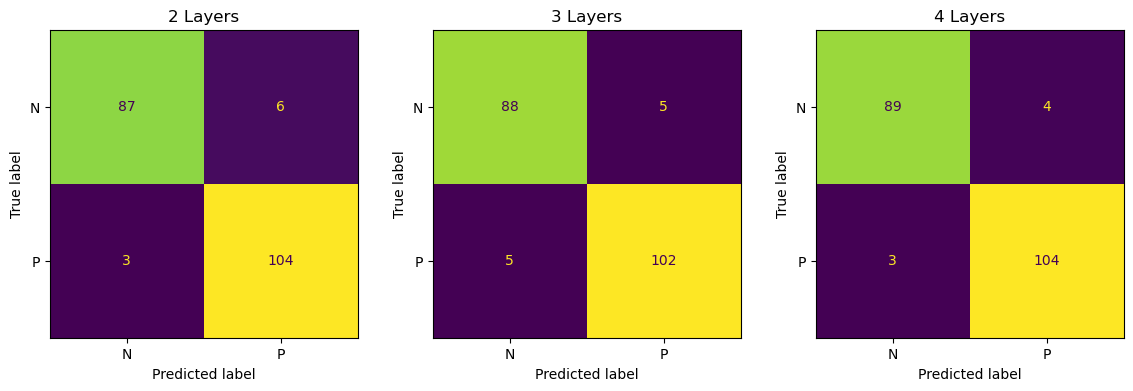

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

disp1 = ConfusionMatrixDisplay(cm_model1, display_labels=['N','P'])
disp1.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title('2 Layers')

disp2 = ConfusionMatrixDisplay(cm_model_2, display_labels=['N','P'])
disp2.plot(ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title('3 Layers')

disp3 = ConfusionMatrixDisplay(cm_model_3, display_labels=['N','P'])
disp3.plot(ax=axes[2], values_format='d', colorbar=False)
axes[2].set_title('4 Layers')

The model with four convolution and max pooling layers performs the best as it has the least number of false negatives and false positives.

Let's experiment with the number of dropout layers next. We will compare four models that have a varying number and combination of dropout layers. Each one will have four convolution and max pooling layers.

##### Dropout

###### No dropout layers:

In [224]:
model2_2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [226]:
model2_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 1,704,961 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [228]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model2_2.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.5486 - loss: 0.7016 - val_accuracy: 0.7950 - val_loss: 0.5027
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.7564 - loss: 0.4961 - val_accuracy: 0.9200 - val_loss: 0.2503
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.9090 - loss: 0.2368 - val_accuracy: 0.9550 - val_loss: 0.1352
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.9404 - loss: 0.1698 - val_accuracy: 0.9450 - val_loss: 0.1400
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - accuracy: 0.9561 - loss: 0.1140 - val_accuracy: 0.9550 - val_loss: 0.1268
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9642 - loss: 0.0924 - val_accuracy: 0.9400 - val_loss: 0.1436
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.9837 - loss: 0.0658 - val_accuracy: 0.9550 - val_loss: 0.1218
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.9739 - loss: 0.0608 - val_accuracy: 0.

In [229]:
y_preds_2_2 = model2_2.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


In [230]:
y_labels_2_2 = (y_preds_2_2 > 0.5).astype(int)

In [231]:
cm_model_2_2 = confusion_matrix(Y_val_sample, y_labels_2_2)

###### Only the first dropout layer:

In [236]:
model2_3 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [238]:
model2_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 1,704,961 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [240]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model2_3.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.5016 - loss: 0.7047 - val_accuracy: 0.8000 - val_loss: 0.6868
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.5843 - loss: 0.6737 - val_accuracy: 0.8900 - val_loss: 0.4017
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - accuracy: 0.8209 - loss: 0.4170 - val_accuracy: 0.9000 - val_loss: 0.2936
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.8321 - loss: 0.3746 - val_accuracy: 0.9350 - val_loss: 0.1977
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.8956 - loss: 0.2666 - val_accuracy: 0.9450 - val_loss: 0.1616
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.9300 - loss: 0.2006 - val_accuracy: 0.9450 - val_loss: 0.1605
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.9306 - loss: 0.1955 - val_accuracy: 0.9500 - val_loss: 0.1445
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.9500 - loss: 0.1488 - val_accuracy: 0.

In [248]:
y_preds_2_3 = model2_3.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [250]:
y_labels_2_3 = (y_preds_2_3 > 0.5).astype(int)

In [252]:
cm_model_2_3 = confusion_matrix(Y_val_sample, y_labels_2_3)

###### Only the second dropout layer:

In [255]:
model2_4 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [257]:
model2_4.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 1,704,961 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [259]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = model2_4.fit(X_train_sample, Y_train_sample, epochs = 30, batch_size = 32, validation_data = (X_val_sample, Y_val_sample), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.5550 - loss: 0.7076 - val_accuracy: 0.4700 - val_loss: 0.6707
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.6606 - loss: 0.5838 - val_accuracy: 0.7950 - val_loss: 0.3945
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.8597 - loss: 0.4058 - val_accuracy: 0.8900 - val_loss: 0.2864
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.9353 - loss: 0.2265 - val_accuracy: 0.9500 - val_loss: 0.1606
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.9525 - loss: 0.1404 - val_accuracy: 0.9400 - val_loss: 0.1733
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.9394 - loss: 0.1660 - val_accuracy: 0.9450 - val_loss: 0.1634
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9544 - loss: 0.1347 - val_accuracy: 0.9450 - val_loss: 0.1455
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.9559 - loss: 0.1335 - val_accuracy: 0.

In [261]:
y_preds_2_4 = model2_4.predict(X_val_sample)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [262]:
y_labels_2_4 = (y_preds_2_4 > 0.5).astype(int)

In [265]:
cm_model_2_4 = confusion_matrix(Y_val_sample, y_labels_2_4)

###### Results: Dropout Layers

Text(0.5, 1.0, 'Two Dropout Layers')

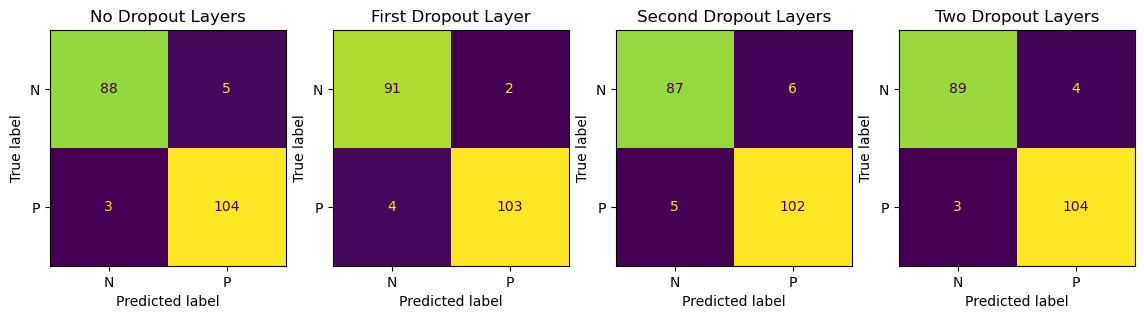

In [267]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

disp1 = ConfusionMatrixDisplay(cm_model_2_2, display_labels=['N','P'])
disp1.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title('No Dropout Layers')

disp2 = ConfusionMatrixDisplay(cm_model_2_3, display_labels=['N','P'])
disp2.plot(ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title('First Dropout Layer')

disp3 = ConfusionMatrixDisplay(cm_model_2_4, display_labels=['N','P'])
disp3.plot(ax=axes[2], values_format='d', colorbar=False)
axes[2].set_title('Second Dropout Layers')

disp4 = ConfusionMatrixDisplay(cm_model_3, display_labels=['N','P'])
disp4.plot(ax=axes[3], values_format='d', colorbar=False)
axes[3].set_title('Two Dropout Layers')

The model with only the first dropout layer performs best.

Let's perform some hyperparameter optimization.

To try to stabilize accuracy, I will start experimenting with and tuning the learning rate. As there is a known relationship between batch size and learning rate, let's try changing batch_size as well.

We will be using GridSearchCV for this task.

##### Hyperparameter Tuning

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:23:06.505838: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.5196 - loss: 0.6996
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.6422 - loss: 0.6552
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.8058 - loss: 0.4601
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.8495 - loss: 0.3849
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - accuracy: 0.9262 - loss: 0.2515
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - accuracy: 0.9317 - loss: 0.2090
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 555ms/step - accuracy: 0.9422 - loss: 0.1581
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step - accuracy: 0.9412 - loss: 0.1462
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - accuracy: 0.9413 - loss: 0.1496
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.9611 - loss: 0.1365
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - accuracy: 0.9457 - loss: 0.1521
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:26:03.423191: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.5278 - loss: 0.7109
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.5949 - loss: 0.6652
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.7741 - loss: 0.5358
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - accuracy: 0.8500 - loss: 0.3442
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.9376 - loss: 0.2062
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step - accuracy: 0.9438 - loss: 0.1901
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - accuracy: 0.9582 - loss: 0.1417
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - accuracy: 0.9669 - loss: 0.1027
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.9764 - loss: 0.0696
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step - accuracy: 0.9714 - loss: 0.0862
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 572ms/step - accuracy: 0.9677 - loss: 0.0896
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 591ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:27:11.175251: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 527ms/step - accuracy: 0.4971 - loss: 0.7051
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - accuracy: 0.5818 - loss: 0.6681
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - accuracy: 0.7582 - loss: 0.5199
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 531ms/step - accuracy: 0.8629 - loss: 0.3345
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step - accuracy: 0.9218 - loss: 0.2161
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - accuracy: 0.9203 - loss: 0.2227
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.9517 - loss: 0.1543
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.9430 - loss: 0.1502
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.9600 - loss: 0.1240
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.9580 - loss: 0.1178
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 526ms/step - accuracy: 0.9546 - loss: 0.1245
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:28:22.215852: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.4871 - loss: 0.7158
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - accuracy: 0.6083 - loss: 0.6722
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - accuracy: 0.7814 - loss: 0.5241
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - accuracy: 0.8802 - loss: 0.3031
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.9143 - loss: 0.2422
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - accuracy: 0.9205 - loss: 0.1883
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - accuracy: 0.9257 - loss: 0.1808
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.9458 - loss: 0.1491
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.9602 - loss: 0.1095
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - accuracy: 0.9652 - loss: 0.1037
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.9614 - loss: 0.1256
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:29:29.133622: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.4711 - loss: 0.7031
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7619 - loss: 0.5246
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9051 - loss: 0.3185
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9132 - loss: 0.2442
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9350 - loss: 0.1415
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9541 - loss: 0.1388
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9442 - loss: 0.1470
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9685 - loss: 0.0922
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9666 - loss: 0.0936
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9627 - loss: 0.0856
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9527 - loss: 0.1138
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:31:00.951755: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.4931 - loss: 0.6970
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.7115 - loss: 0.5714
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.8784 - loss: 0.3492
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9093 - loss: 0.2510
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9478 - loss: 0.1513
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9496 - loss: 0.1167
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9628 - loss: 0.0936
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9678 - loss: 0.0945
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9541 - loss: 0.1026
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9683 - loss: 0.0811
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9738 - loss: 0.0662
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:32:45.695715: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.5096 - loss: 0.7015
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.8207 - loss: 0.4399
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9207 - loss: 0.2495
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9161 - loss: 0.2330
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9390 - loss: 0.1706
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9651 - loss: 0.1274
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9639 - loss: 0.1271
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9565 - loss: 0.1090
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9640 - loss: 0.0859
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9645 - loss: 0.0744
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9686 - loss: 0.0776
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:34:40.940995: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.5479 - loss: 0.7110
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7794 - loss: 0.5222
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.8771 - loss: 0.3307
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8639 - loss: 0.3461
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9356 - loss: 0.1551
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9248 - loss: 0.2096
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.9571 - loss: 0.1417
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9166 - loss: 0.1941
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:35:28.432349: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.4982 - loss: 0.7363
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.5456 - loss: 0.6779
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.8332 - loss: 0.4555
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.8769 - loss: 0.3354
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.9075 - loss: 0.2434
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.9545 - loss: 0.1712
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.9533 - loss: 0.1295
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - accuracy: 0.9570 - loss: 0.1214
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.9655 - loss: 0.0958
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.9627 - loss: 0.0641
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.9703 - loss: 0.0791
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:36:42.535516: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.4799 - loss: 0.7174
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.5798 - loss: 0.6832
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.7946 - loss: 0.5255
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.8796 - loss: 0.3208
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.9304 - loss: 0.2159
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.9461 - loss: 0.1508
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.9517 - loss: 0.1548
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.9635 - loss: 0.1317
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.9690 - loss: 0.0806
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.9668 - loss: 0.0632
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.9689 - loss: 0.0686
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:37:56.563283: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.5254 - loss: 0.6924
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.7860 - loss: 0.4842
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.8758 - loss: 0.2964
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.9211 - loss: 0.2312
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9182 - loss: 0.2279
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.9488 - loss: 0.1494
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.9465 - loss: 0.1539
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9634 - loss: 0.0943
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.9650 - loss: 0.0875
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.9632 - loss: 0.0886
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.9678 - loss: 0.0720
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:40:29.585124: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.5354 - loss: 0.7256
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.7284 - loss: 0.5702
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.8468 - loss: 0.3993
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.8695 - loss: 0.3165
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.9388 - loss: 0.1686
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.9326 - loss: 0.1784
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9385 - loss: 0.1564
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.9594 - loss: 0.1190
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - accuracy: 0.9466 - loss: 0.1054
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9602 - loss: 0.1135
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.9651 - loss: 0.0849
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:42:05.418785: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.4859 - loss: 0.6983
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.6801 - loss: 0.6269
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8587 - loss: 0.3859
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8992 - loss: 0.2604
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9317 - loss: 0.2104
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9470 - loss: 0.1797
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9453 - loss: 0.1497
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9631 - loss: 0.1160
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9605 - loss: 0.1173
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9553 - loss: 0.1073
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9383 - loss: 0.1312
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:43:45.946718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.4961 - loss: 0.6931
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.7587 - loss: 0.5286
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.8879 - loss: 0.3134
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9281 - loss: 0.1978
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9445 - loss: 0.1695
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9402 - loss: 0.1738
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9495 - loss: 0.1592
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9413 - loss: 0.1493
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9642 - loss: 0.0967
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9714 - loss: 0.1024
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9758 - loss: 0.0782
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:45:25.273130: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.4944 - loss: 0.6916
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7156 - loss: 0.5782
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8678 - loss: 0.3248
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.9236 - loss: 0.2167
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9315 - loss: 0.1651
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9649 - loss: 0.1193
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9592 - loss: 0.1638
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9430 - loss: 0.1569
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9578 - loss: 0.1288
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9714 - loss: 0.0985
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9704 - loss: 0.0749
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:47:08.249515: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.5165 - loss: 0.7024
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.6077 - loss: 0.6509
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8600 - loss: 0.3834
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8799 - loss: 0.2798
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.9305 - loss: 0.1862
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9408 - loss: 0.1630
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9368 - loss: 0.1498
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9443 - loss: 0.1756
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9752 - loss: 0.1112
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9653 - loss: 0.1074
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9668 - loss: 0.1227
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:49:18.830760: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 601ms/step - accuracy: 0.5237 - loss: 0.7147
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 580ms/step - accuracy: 0.6352 - loss: 0.6736
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - accuracy: 0.7727 - loss: 0.5172
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.8613 - loss: 0.3503
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - accuracy: 0.8907 - loss: 0.3011
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - accuracy: 0.9467 - loss: 0.2084
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - accuracy: 0.9504 - loss: 0.1480
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 815ms/step - accuracy: 0.9581 - loss: 0.1364
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.9340 - loss: 0.1532
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 614ms/step - accuracy: 0.9432 - loss: 0.1492
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step - accuracy: 0.9520 - loss: 0.1146
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 609ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:51:15.472469: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.5084 - loss: 0.7373
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.5786 - loss: 0.6682
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 770ms/step - accuracy: 0.7568 - loss: 0.5693
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.8217 - loss: 0.4334
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 646ms/step - accuracy: 0.8814 - loss: 0.3437
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step - accuracy: 0.9081 - loss: 0.2627
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.9428 - loss: 0.1659
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.9597 - loss: 0.1503
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.9670 - loss: 0.0951
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.9578 - loss: 0.1108
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9503 - loss: 0.1311
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:53:40.886806: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step - accuracy: 0.4735 - loss: 0.7183
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.5218 - loss: 0.6906
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.6691 - loss: 0.6002
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.8480 - loss: 0.3811
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - accuracy: 0.9088 - loss: 0.2725
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.9292 - loss: 0.1833
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.9503 - loss: 0.1852
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 643ms/step - accuracy: 0.9281 - loss: 0.1796
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 796ms/step - accuracy: 0.9308 - loss: 0.1654
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.9228 - loss: 0.1998
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.9399 - loss: 0.1610
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:55:52.441014: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 760ms/step - accuracy: 0.4859 - loss: 0.7474
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.5369 - loss: 0.6813
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 902ms/step - accuracy: 0.7692 - loss: 0.5016
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.8604 - loss: 0.3500
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step - accuracy: 0.9027 - loss: 0.2436
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 632ms/step - accuracy: 0.9311 - loss: 0.1919
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 751ms/step - accuracy: 0.9234 - loss: 0.1816
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - accuracy: 0.9555 - loss: 0.1379
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.9551 - loss: 0.1217
Epoch 10/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.9350 - loss: 0.1823
Epoch 11/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step - accuracy: 0.9367 - loss: 0.1726
Epoch 12/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 655ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:57:20.282948: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4639 - loss: 0.7078
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7539 - loss: 0.5888
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8493 - loss: 0.3920
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9084 - loss: 0.2240
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.9133 - loss: 0.2099
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9635 - loss: 0.1334
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9558 - loss: 0.1075
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9631 - loss: 0.0984
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9633 - loss: 0.0752
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9803 - loss: 0.0548
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9773 - loss: 0.0728
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 19:59:05.208428: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.4763 - loss: 0.6999
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.7799 - loss: 0.5200
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9021 - loss: 0.2856
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9316 - loss: 0.1873
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9415 - loss: 0.1509
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9572 - loss: 0.1212
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9620 - loss: 0.0977
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9838 - loss: 0.0771
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9659 - loss: 0.0731
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9724 - loss: 0.0813
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9829 - loss: 0.0511
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 20:00:50.617848: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.5012 - loss: 0.7171
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8256 - loss: 0.4548
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.8813 - loss: 0.3344
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9223 - loss: 0.2665
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9481 - loss: 0.1444
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9381 - loss: 0.1671
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9596 - loss: 0.1229
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9695 - loss: 0.0878
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9627 - loss: 0.0745
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9539 - loss: 0.1175
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9631 - loss: 0.0834
Epoch 11: early stopping
Restoring model weights from the end o

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-23 20:01:57.920872: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.5577 - loss: 0.7357
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.8060 - loss: 0.4477
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.8942 - loss: 0.2796
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.9061 - loss: 0.2355
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9286 - loss: 0.1717
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9587 - loss: 0.1737
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.9552 - loss: 0.1322
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9579 - loss: 0.1084
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9637 - loss: 0.0857
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9744 - loss: 0.0656
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9789 - loss: 0.0540
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.4986 - loss: 0.6961
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7750 - loss: 0.4951
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.9319 - loss: 0.2505
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9331 - loss: 0.2149
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9402 - loss: 0.1889
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9517 - loss: 0.1567
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.9643 - loss: 0.0994
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9674 - loss: 0.0941
Epoch 9/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9814 - loss: 0.0544
Epoch 10/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9694 - loss: 0.0976
Epoch 11/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9755 - loss: 0.0746
Epoch 12/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy

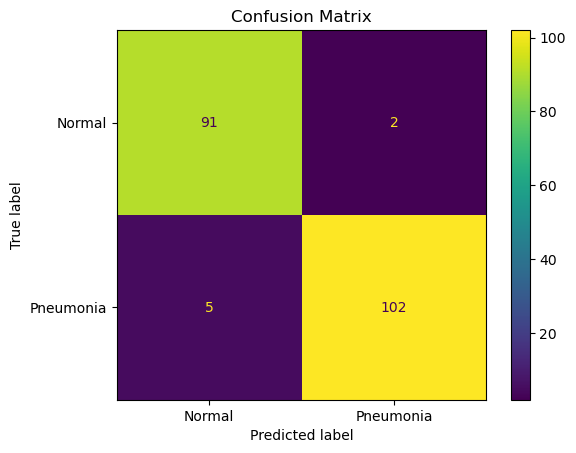

In [285]:
def NN_model(learning_rate=0.001):
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2,2)),
        
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
    
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
    
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, verbose=1)

classifier = KerasClassifier(
    model=NN_model,
    epochs=40,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop],
    random_state=42,
    learning_rate=0.001
)

param_distributions = {
    "learning_rate": [0.0005, 0.001, 0.0015],
    "batch_size": [16, 32, 64]
}


search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_distributions,
    n_iter=6,
    scoring='accuracy',
    refit=True,
    cv=4,
    n_jobs=1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

search.fit(X_train_sample, Y_train_sample)

print("Best parameters:", search.best_params_)
print("Best validation accuracy:", search.best_score_)

y_preds = search.best_estimator_.predict(X_val_sample)
y_labels = (y_preds > 0.5).astype(int)

print("Test accuracy:",  accuracy_score(Y_val_sample, y_labels))


cm_search = confusion_matrix(Y_val_sample, y_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_search, display_labels=["Normal", "Pneumonia"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

The optimal hyperparameters for this model are a learning rate of 0.001 and a batch size of 16.

Our final model will have 4 Conv2D and Max Pooling layers, one dropout layer after the first FCL, a learning rate of 0.001 and a batch size of 16. 

Now that we have determined the optimal model architecture and hyperparameters, we will retrain this model on a larger set of images then apply it on the testing set to see final model performance.

#### Final Model Training

In [298]:
final_model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate = 0.001)

final_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [300]:
final_model.summary()

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_331 (Conv2D)             │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_331               │ (None, 127, 127, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_332 (Conv2D)             │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_332               │ (None, 62, 62, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_333 (Conv2D)             │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_333               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_334 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_334               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_84 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 1,704,961 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [302]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

fitting = final_model.fit(X_train, Y_train, epochs = 30, batch_size = 16, validation_data = (X_val, Y_val), callbacks = [early_stop])

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.5888 - loss: 0.6389 - val_accuracy: 0.8981 - val_loss: 0.3104
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.8968 - loss: 0.2715 - val_accuracy: 0.9426 - val_loss: 0.1480
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9348 - loss: 0.1608 - val_accuracy: 0.9611 - val_loss: 0.1173
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.9555 - loss: 0.1233 - val_accuracy: 0.9611 - val_loss: 0.1094
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.9626 - loss: 0.0998 - val_accuracy: 0.9685 - val_loss: 0.1008
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9644 - loss: 0.0965 - val_accuracy: 0.9648 - val_loss: 0.1018
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9752 - loss: 0.0713 - val_accuracy: 0.9574 - val_loss: 0.1240
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.9760 - loss: 0

In [304]:
final_y_preds = final_model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [306]:
final_y_labels = (final_y_preds > 0.5).astype(int)

In [308]:
final_model_cm = confusion_matrix(Y_test, final_y_labels)

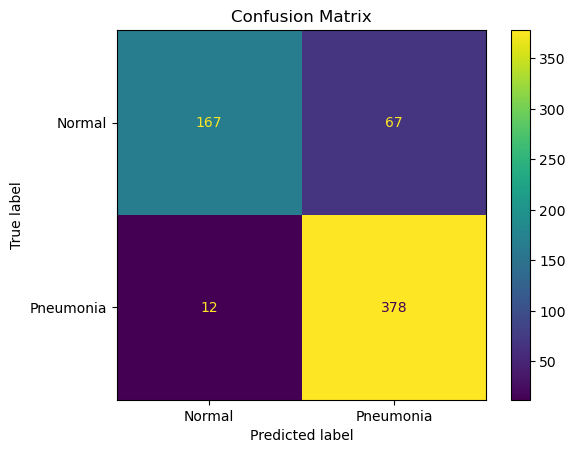

In [310]:
disp = ConfusionMatrixDisplay(confusion_matrix=final_model_cm, display_labels=["Normal", "Pneumonia"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [316]:
final_accuracy = accuracy_score(Y_test, final_y_labels)
final_precision = precision_score(Y_test, final_y_labels)
final_recall = recall_score(Y_test, final_y_labels)
final_f1 = f1_score(Y_test, final_y_labels)

print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")

Accuracy: 0.8734
Precision: 0.8494
Recall: 0.9692
F1 Score: 0.9054


We can see that our model performed decently well, being able to correctly classify over 87% of the cases.

### Discussion of Final Results

After applying the testing set to our best model, we achieved a testing accuracy of 87.34% which means that the model correctly predicted about 87% of the test cases.

Precision of our model was almost 85%. This means that out of all predicted pneumonia cases, about 85% of them were correct. This means that approximately 15% of cases were false positives and that those patients were flagged as sick when they weren't.

Recall was over about 97% which means that the model caught about 97% of actual pneumonia cases and that there were very few false negatives. This is a very important statistic in the healthcare field since missing a true pneumonia case could be dangerous.

Lastly, our F1 score was about 90% meaning that our model can identify pneumonia cases without too many false positives.

I believe that this model can be very useful in detecting pneumonia from chest X-ray images as accuracy is decently high and recall is excellent. In the healthcare field, not flagging a sick person is more dangerous than falsely flagging a healthy person. With my model achieving a recall of almost 97%, this means that the great majority of those with pneumonia were flagged and thus can receive treatment. That being said, my model lacks in that it flags healthy patients as having pneumonia more often than desired.

### Conclusion

After building a neural network model that aims to identify pneumonia in chest X-ray images, we were able to achieve an accuracy of over 87%, with a recall of about 97%. This was via an architecture with 4 convolutional and max-pooling layers, two dense or fully connected layers, and a dropout layer in between the two dense layers before applying the single neuron dense layer that makes the final decision. After experimenting with different learning rates and batch sizes, we determined that the best model was one with a learning rate of 0.001 and a batch size of 16. 

The biggest things that helped improve the performance of this model were adding additional 2D convolution and max pooling layers. This helped by allowing the model to be able to learn complex patterns and reduce the dimensions of the images we were working with without losing those patterns. Hyperparameter tuning was then able to adjust the model and slightly boost performance. 

In order to further improve this model, the number and size of filters applied at each convolutional layer can be experimented with, as it can refine the computer's vision and further improve model performance.

If I had access to better hardware, I would increase the number of images I feed into my model. I believe that would better train the model since it sees more examples of negative and positive pneumonia cases. This can be simply done by applying a rotation to or mirroring the images we have in this dataset. In addition, I can increase the size of each image so that the model has a better view to work with.